In [52]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import os

In [54]:
# 1. Load dataset
df = pd.read_json(r"C:\Users\bbuser\Downloads\News_Category_Dataset_v3.json", lines=True)

In [55]:
# Keep only required categories
categories = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
df = df[df['category'].isin(categories)]

In [56]:

# Keep only short_description and category
df = df[['short_description', 'category']]

In [57]:
# Balance dataset: 1000 samples per category
df = df.groupby('category').apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)

C:\Users\bbuser\AppData\Local\Temp\ipykernel_7748\3793788927.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('category').apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)


In [58]:
# Stratified 80/20 split
train, test = train_test_split(
    df, test_size=0.2, stratify=df['category'], random_state=42
)

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (3200, 2)
Test size: (800, 2)


In [59]:
# 2. Preprocessing Helper Functions
# -------------------------------
def preprocess(text):
    """Lowercase, remove punctuation, tokenize"""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

def get_top_words(texts, n=10):
    """Get top N frequent words from a list of texts"""
    all_words = []
    for t in texts:
        all_words.extend(preprocess(t))
    counter = Counter(all_words)
    return [w for w, _ in counter.most_common(n)]


In [60]:
# 3. Generate Word Clouds & Frequent Words
# -------------------------------
os.makedirs("wordclouds", exist_ok=True)

top_words = {}
for cat in categories:
    cat_texts = train[train['category'] == cat]['short_description']
    
    # Word Cloud
    text_all = " ".join(cat_texts)
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_all)
    wc.to_file(f"wordclouds/{cat}.png")
    
    # Save top 50 words
    top_words[cat] = get_top_words(cat_texts, n=50)

print("Top words per category (first 10 shown):")
for cat in categories:
    print(cat, ":", top_words[cat][:10])


Top words per category (first 10 shown):
POLITICS : ['the', 'to', 'of', 'a', 'and', 'is', 'in', 'that', 'for', 'on']
TRAVEL : ['the', 'of', 'to', 'a', 'and', 'in', 'is', 'you', 'for', 'that']
SPORTS : ['the', 'a', 'to', 'in', 'of', 'and', 'is', 'for', 'on', 'was']
HOME & LIVING : ['the', 'to', 'a', 'and', 'of', 'you', 'in', 'for', 'your', 'this']


In [61]:
# 4. Keyword-Based Classification
# -------------------------------
def classify(text, n_words=10):
    """Classify text using top N frequent words per category"""
    words = set(preprocess(text))
    scores = {cat: len(words & set(top_words[cat][:n_words])) for cat in categories}
    max_score = max(scores.values())
    
    # Handle tie
    if list(scores.values()).count(max_score) > 1:
        return "unknown"
    
    return max(scores, key=scores.get)


In [62]:
# 5. Experimentation
# -------------------------------
results = {}
for n in [10, 20, 30, 50]:
    preds = [classify(t, n_words=n) for t in test['short_description']]
    # Remove "unknown" before accuracy calculation
    mask = np.array(preds) != "unknown"
    acc = np.mean(np.array(preds)[mask] == test['category'][mask])
    coverage = np.mean(mask)  # fraction of test samples not tied
    results[n] = (acc, coverage)
    print(f"Top {n} words → Accuracy: {acc:.3f}, Coverage: {coverage:.2f}")


Top 10 words → Accuracy: 0.453, Coverage: 0.20
Top 20 words → Accuracy: 0.467, Coverage: 0.36
Top 30 words → Accuracy: 0.487, Coverage: 0.34
Top 50 words → Accuracy: 0.594, Coverage: 0.33


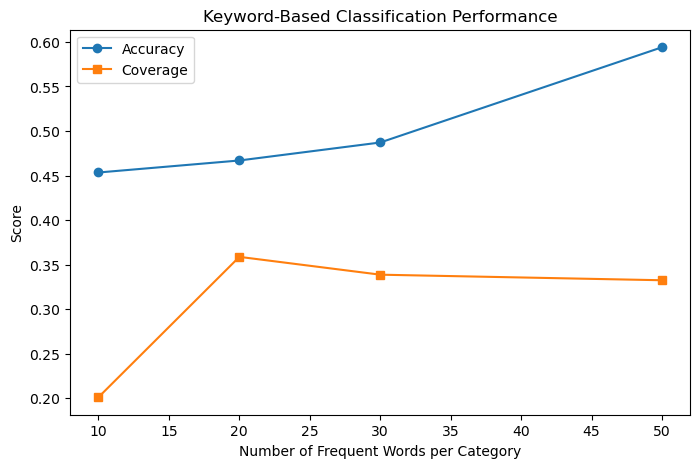

In [63]:
# 6. Plot Results
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(results.keys(), [v[0] for v in results.values()], marker='o', label="Accuracy")
plt.plot(results.keys(), [v[1] for v in results.values()], marker='s', label="Coverage")
plt.xlabel("Number of Frequent Words per Category")
plt.ylabel("Score")
plt.title("Keyword-Based Classification Performance")
plt.legend()
plt.show()